In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# DISABLING GPU to prevent Windows freeze
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

# --- ROBUST PATH DETECTION ---
# Check where we are currently standing
current_loc = Path(os.getcwd())
print(f"Running from: {current_loc}")

# Logic: If 'data' is right here, we are at Root. If not, try going up one level.
if (current_loc / "data").exists():
    BASE_DIR = current_loc
    print("Detected Project Root as Base.")
elif (current_loc.parent / "data").exists():
    BASE_DIR = current_loc.parent
    print("Detected Parent Directory as Base.")
else:
    raise FileNotFoundError(f"CRITICAL: Could not find 'data' folder! checked {current_loc} and {current_loc.parent}")

PROCESSED_DIR = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Verify specific training folder exists
train_dir = PROCESSED_DIR / "train"
if not train_dir.exists():
    raise FileNotFoundError(f"Training folder missing at: {train_dir}")
else:
    print(f"Targeting Data Directory: {PROCESSED_DIR}")

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

Running from: c:\Users\yashk\Documents\Projects\RealWorldProblems\EcoVision_AI\notebooks
Detected Parent Directory as Base.
Targeting Data Directory: c:\Users\yashk\Documents\Projects\RealWorldProblems\EcoVision_AI\data\processed


Load Data

In [2]:
# 1. Training Data (with data augmentation for robustness)
train_ds = tf.keras.utils.image_dataset_from_directory(
    PROCESSED_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical', # We have 10 classes
    shuffle=True
)

# 2. Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    PROCESSED_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False 
)

# 3. Test Data
test_ds = tf.keras.utils.image_dataset_from_directory(
    PROCESSED_DIR / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Performance tweak: Prefetching loads the next batch while the GPU works on the current one
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 20938 files belonging to 10 classes.
Found 2618 files belonging to 10 classes.
Found 2623 files belonging to 10 classes.
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


Transfer Learning

In [3]:
# 1. Load the Pre-trained Base
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,), # 224, 224, 3 channels (RGB)
    include_top=False,           # Drop the original classification layer
    weights='imagenet'           # Use learned weights
)

# 2. Freeze the Base
# We don't want to destroy the pre-trained knowledge, so we make the base non-trainable initially.
base_model.trainable = False

# 3. Create the Full Architecture
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
# Preprocessing: MobileNet expects pixels [-1, 1], but ours are [0, 255]
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs) 

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Flatten the features
x = layers.Dropout(0.2)(x)             # Prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x) # 10 Output Neurons

model = models.Model(inputs, outputs)

# 4. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training

In [4]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 538s 811ms/step - accuracy: 0.9290 - loss: 0.2520 - val_accuracy: 0.9511 - val_loss: 0.1611
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.9652 - loss: 0.1173 - val_accuracy: 0.9542 - val_loss: 0.1476
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 629s 949ms/step - accuracy: 0.9704 - loss: 0.0981 - val_accuracy: 0.9553 - val_loss: 0.1505
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 592s 903ms/step - accuracy: 0.9732 - loss: 0.0879 - val_accuracy: 0.9568 - val_loss: 0.1608
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 581s 887ms/step - accuracy: 0.9773 - loss: 0.0762 - val_accuracy: 0.9561 - val_loss: 0.1525


Test

In [5]:
# 1. Evaluate on Test Set (Unseen data)
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 2. Save the Model
save_path = MODELS_DIR / "animal_classifier.keras"
model.save(save_path)
print(f"Model saved to {save_path}")

# 3. Save class names (We need these for the app later!)
import json
class_map_path = MODELS_DIR / "class_indices.json"
# Create a dictionary mapping index to class name
class_map = {i: name for i, name in enumerate(class_names)}
with open(class_map_path, 'w') as f:
    json.dump(class_map, f)
print("Class map saved.")

82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 549ms/step - accuracy: 0.9588 - loss: 0.1489
Test Accuracy: 95.88%
Model saved to c:\Users\yashk\Documents\Projects\RealWorldProblems\EcoVision_AI\models\animal_classifier.keras
Class map saved.


Performance?

Running predictions on Test Set...


<Figure size 1200x1000 with 0 Axes>

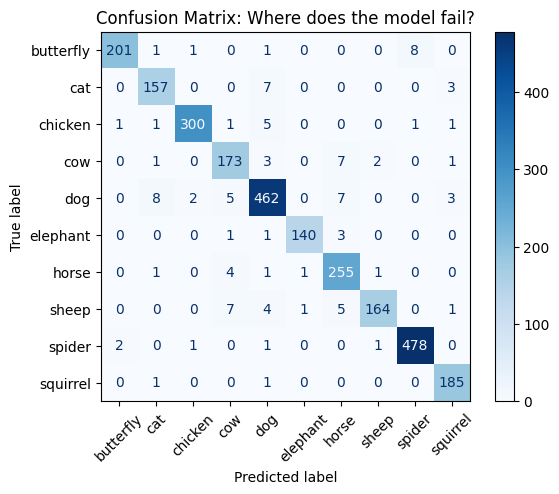

In [7]:
# 1. Get True Labels and Predictions
# We need to loop through the test set because it's batched
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels = []
predictions = []

print("Running predictions on Test Set...")
for images, labels in test_ds:
    # Predict
    preds = model.predict(images, verbose=0)
    
    # Convert One-Hot encoding back to index (e.g., [0, 0, 1, 0] -> 2)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions.extend(np.argmax(preds, axis=1))

true_labels = np.array(true_labels)
predictions = np.array(predictions)

# 2. Compute Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# 3. Plot
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')

plt.title('Confusion Matrix: Where does the model fail?')
plt.show()